In [3]:
import os
import pickle
if not os.path.basename(os.getcwd()) in ["nas", "ea-nas", "EA-architecture-search"]:
    os.chdir("../")
print(f"Current workdirectory: {os.getcwd()}")

storage_dir = r"/Volumes/1TB-RED"
config_dir = f"{storage_dir}/configs"
results_dir = f"{storage_dir}/results"

for directory in [storage_dir, config_dir, results_dir]:
    if not os.path.isdir(directory):
        print(f"ERROR: {directory} is not a directory")

Current workdirectory: /Users/magnus/Projects/Python/EA-architecture-search


# Setting up one experiment for analysis: 

In [4]:
from src.configuration import Configuration

In [5]:
from LAB.common import Simulation

In [6]:
exp02 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp02")
exp03 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp03")
# exp03 = Simulation.read_all_genotypes_per_generation(config_dir, results_dir, "exp05")

Loading exp02
 - Reading files, 100% complete			
 - population sorted into generations
Loading exp03
 - Reading files, 100% complete			
 - population sorted into generations


In [134]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (100,60)

def plot_setup(ax, title):
    plt.title(title, y=1.08)
    plt.setp(ax.title, fontsize=124)
    plt.setp(ax.get_xticklabels(), fontsize=64)
    plt.setp(ax.get_yticklabels(), fontsize=64)
    ax.legend(fontsize=72)

def plotter(x, y, labels, title):
    ax = plt.subplot(111)
    for i in range(len(x)):
        plt.plot(y, x[i], linewidth=15, label=labels[i])
    plot_setup(ax, title)
    plt.plot()
    plt.savefig(f"/Users/magnus/Desktop/{title}.png")

# Looking at statistics for each generation

We are starting with accuracies for the test set.

In [99]:
def plot_acc(exp, title="Min - Max - Average test accuracies"):
    gens = list(range(len(exp.avg_test_acc)))
    plotter(
        x=[
            exp.max_test_acc,
            exp.avg_test_acc,
            exp.min_test_acc
        ], 
        y=gens, 
        labels=[
            "Maximum test accuracy",
            "Average test accuracy",
            "Minimum test accuracy"
        ], 
        title=title
    )

plotting Maximum test accuracy
plotting Average test accuracy
plotting Minimum test accuracy


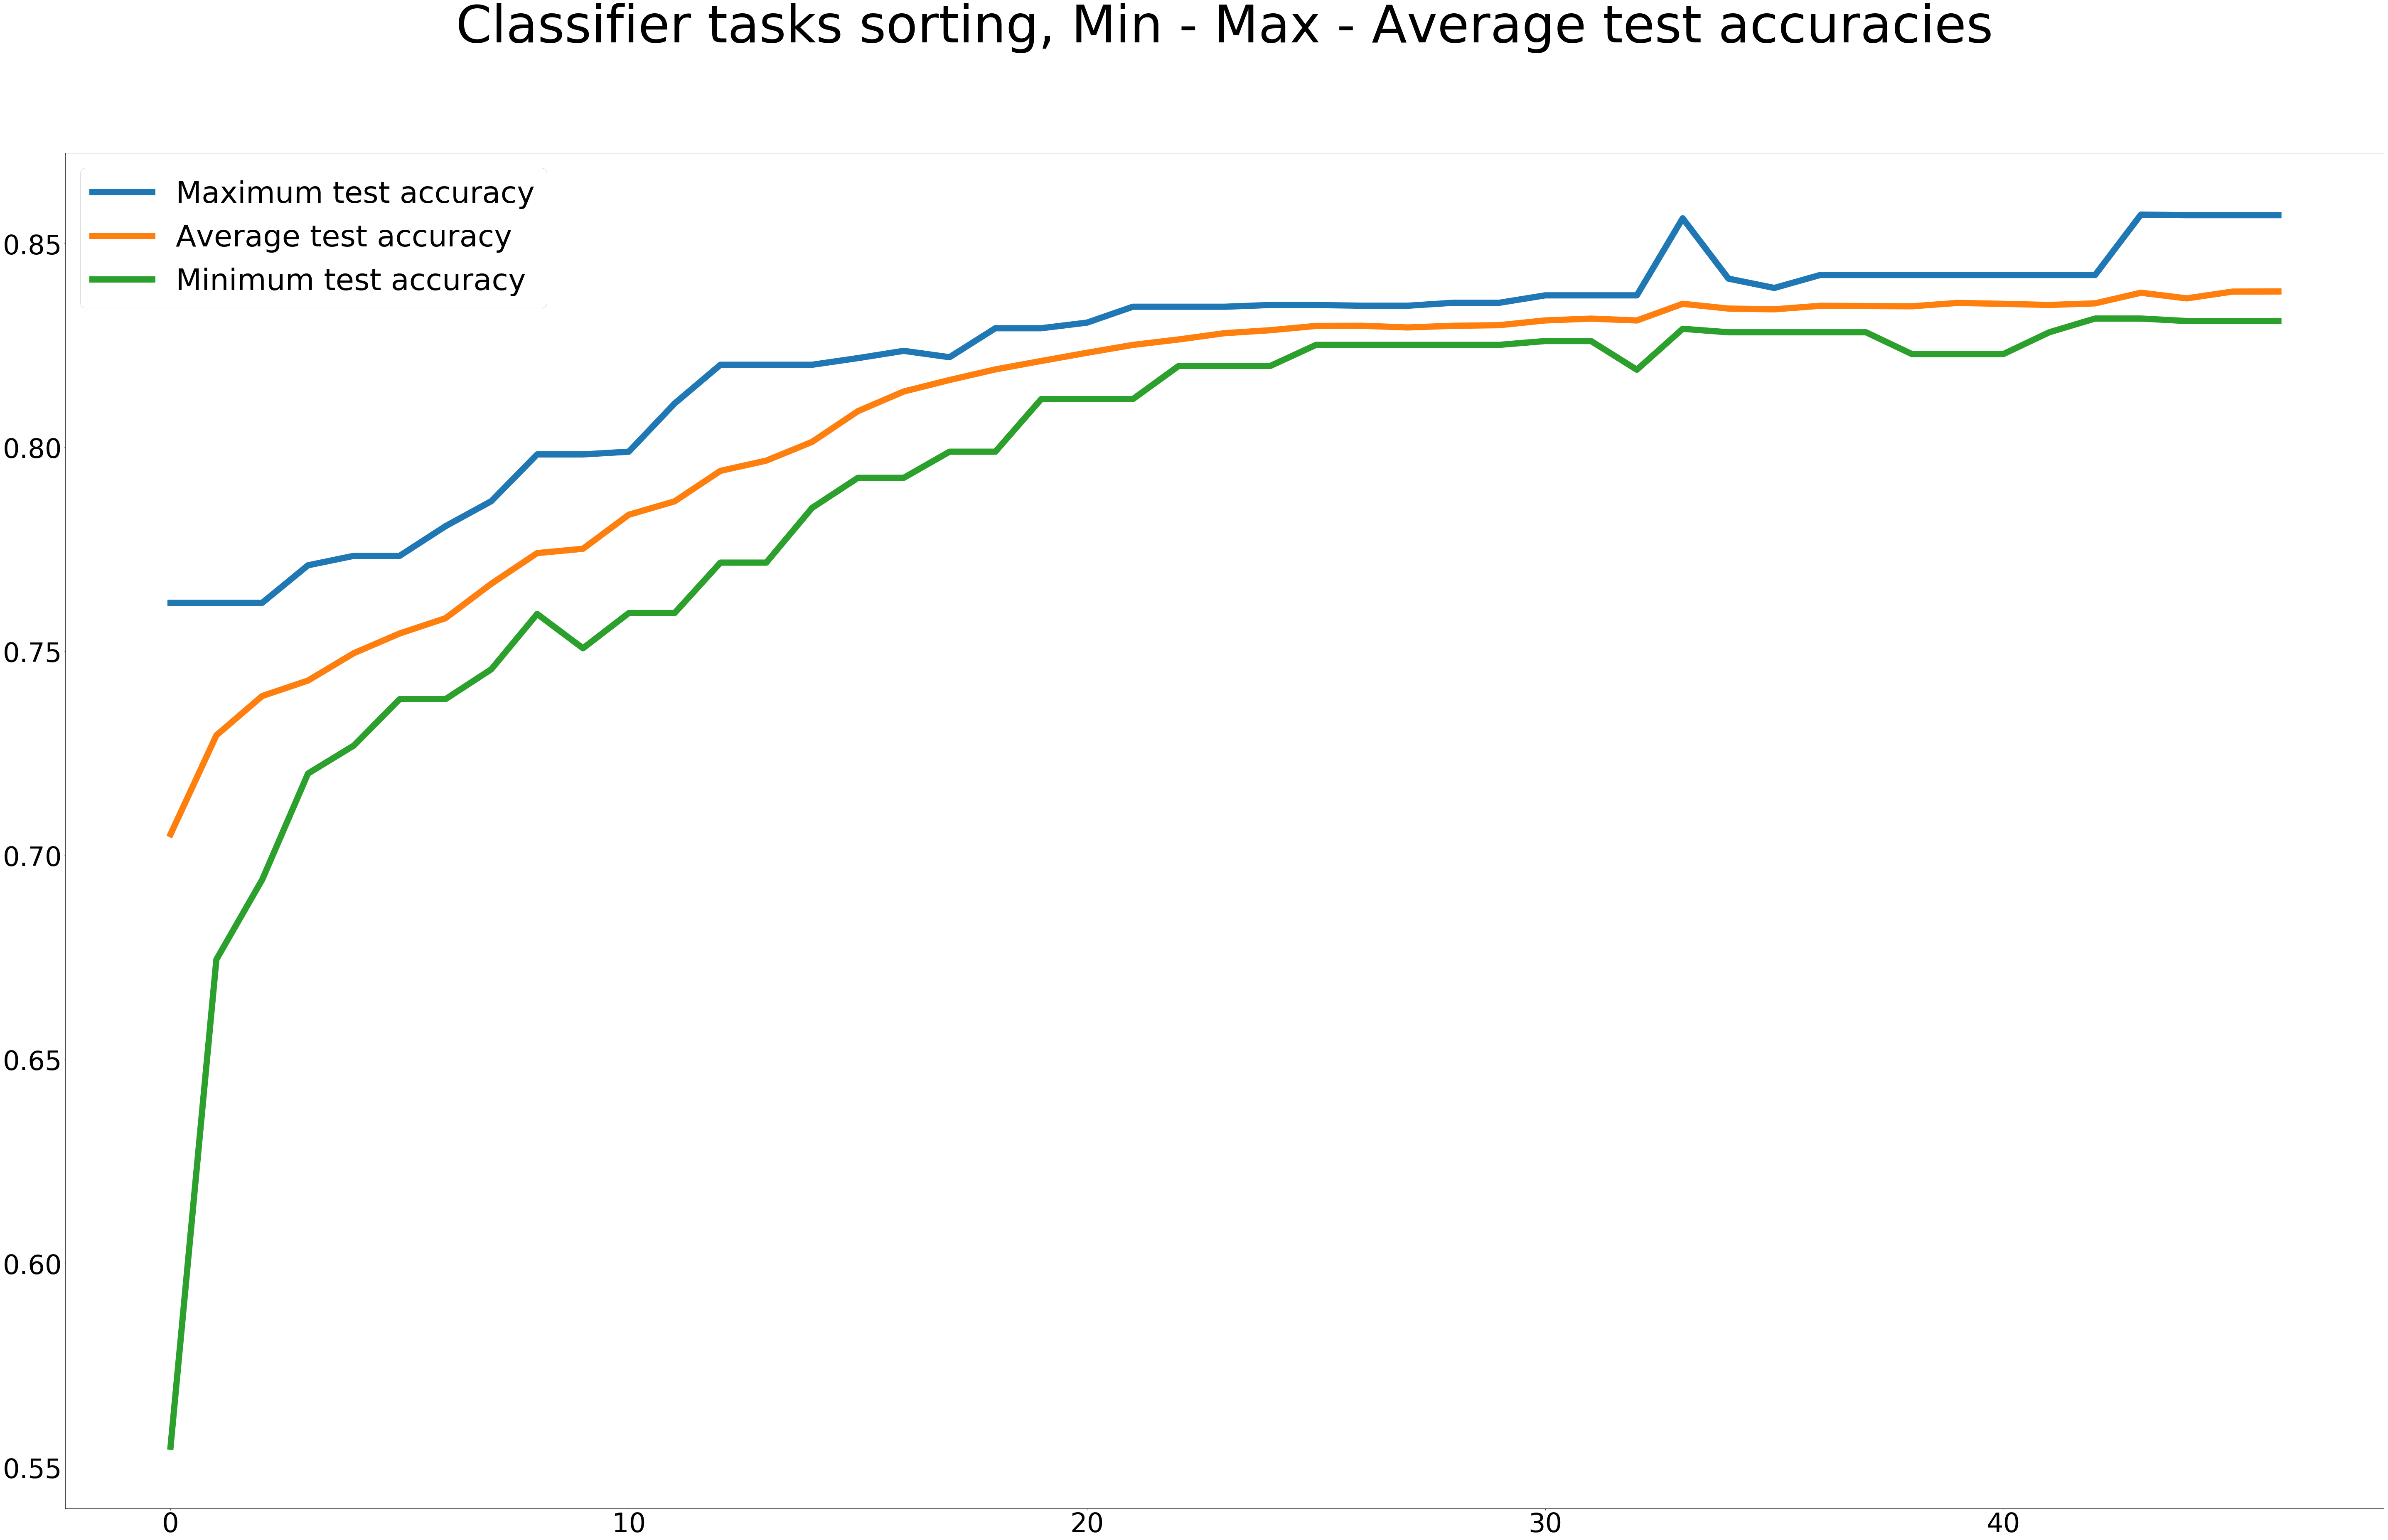

In [100]:
plot_acc(exp02, "Classifier tasks sorting, Min - Max - Average test accuracies")

plotting Maximum test accuracy
plotting Average test accuracy
plotting Minimum test accuracy


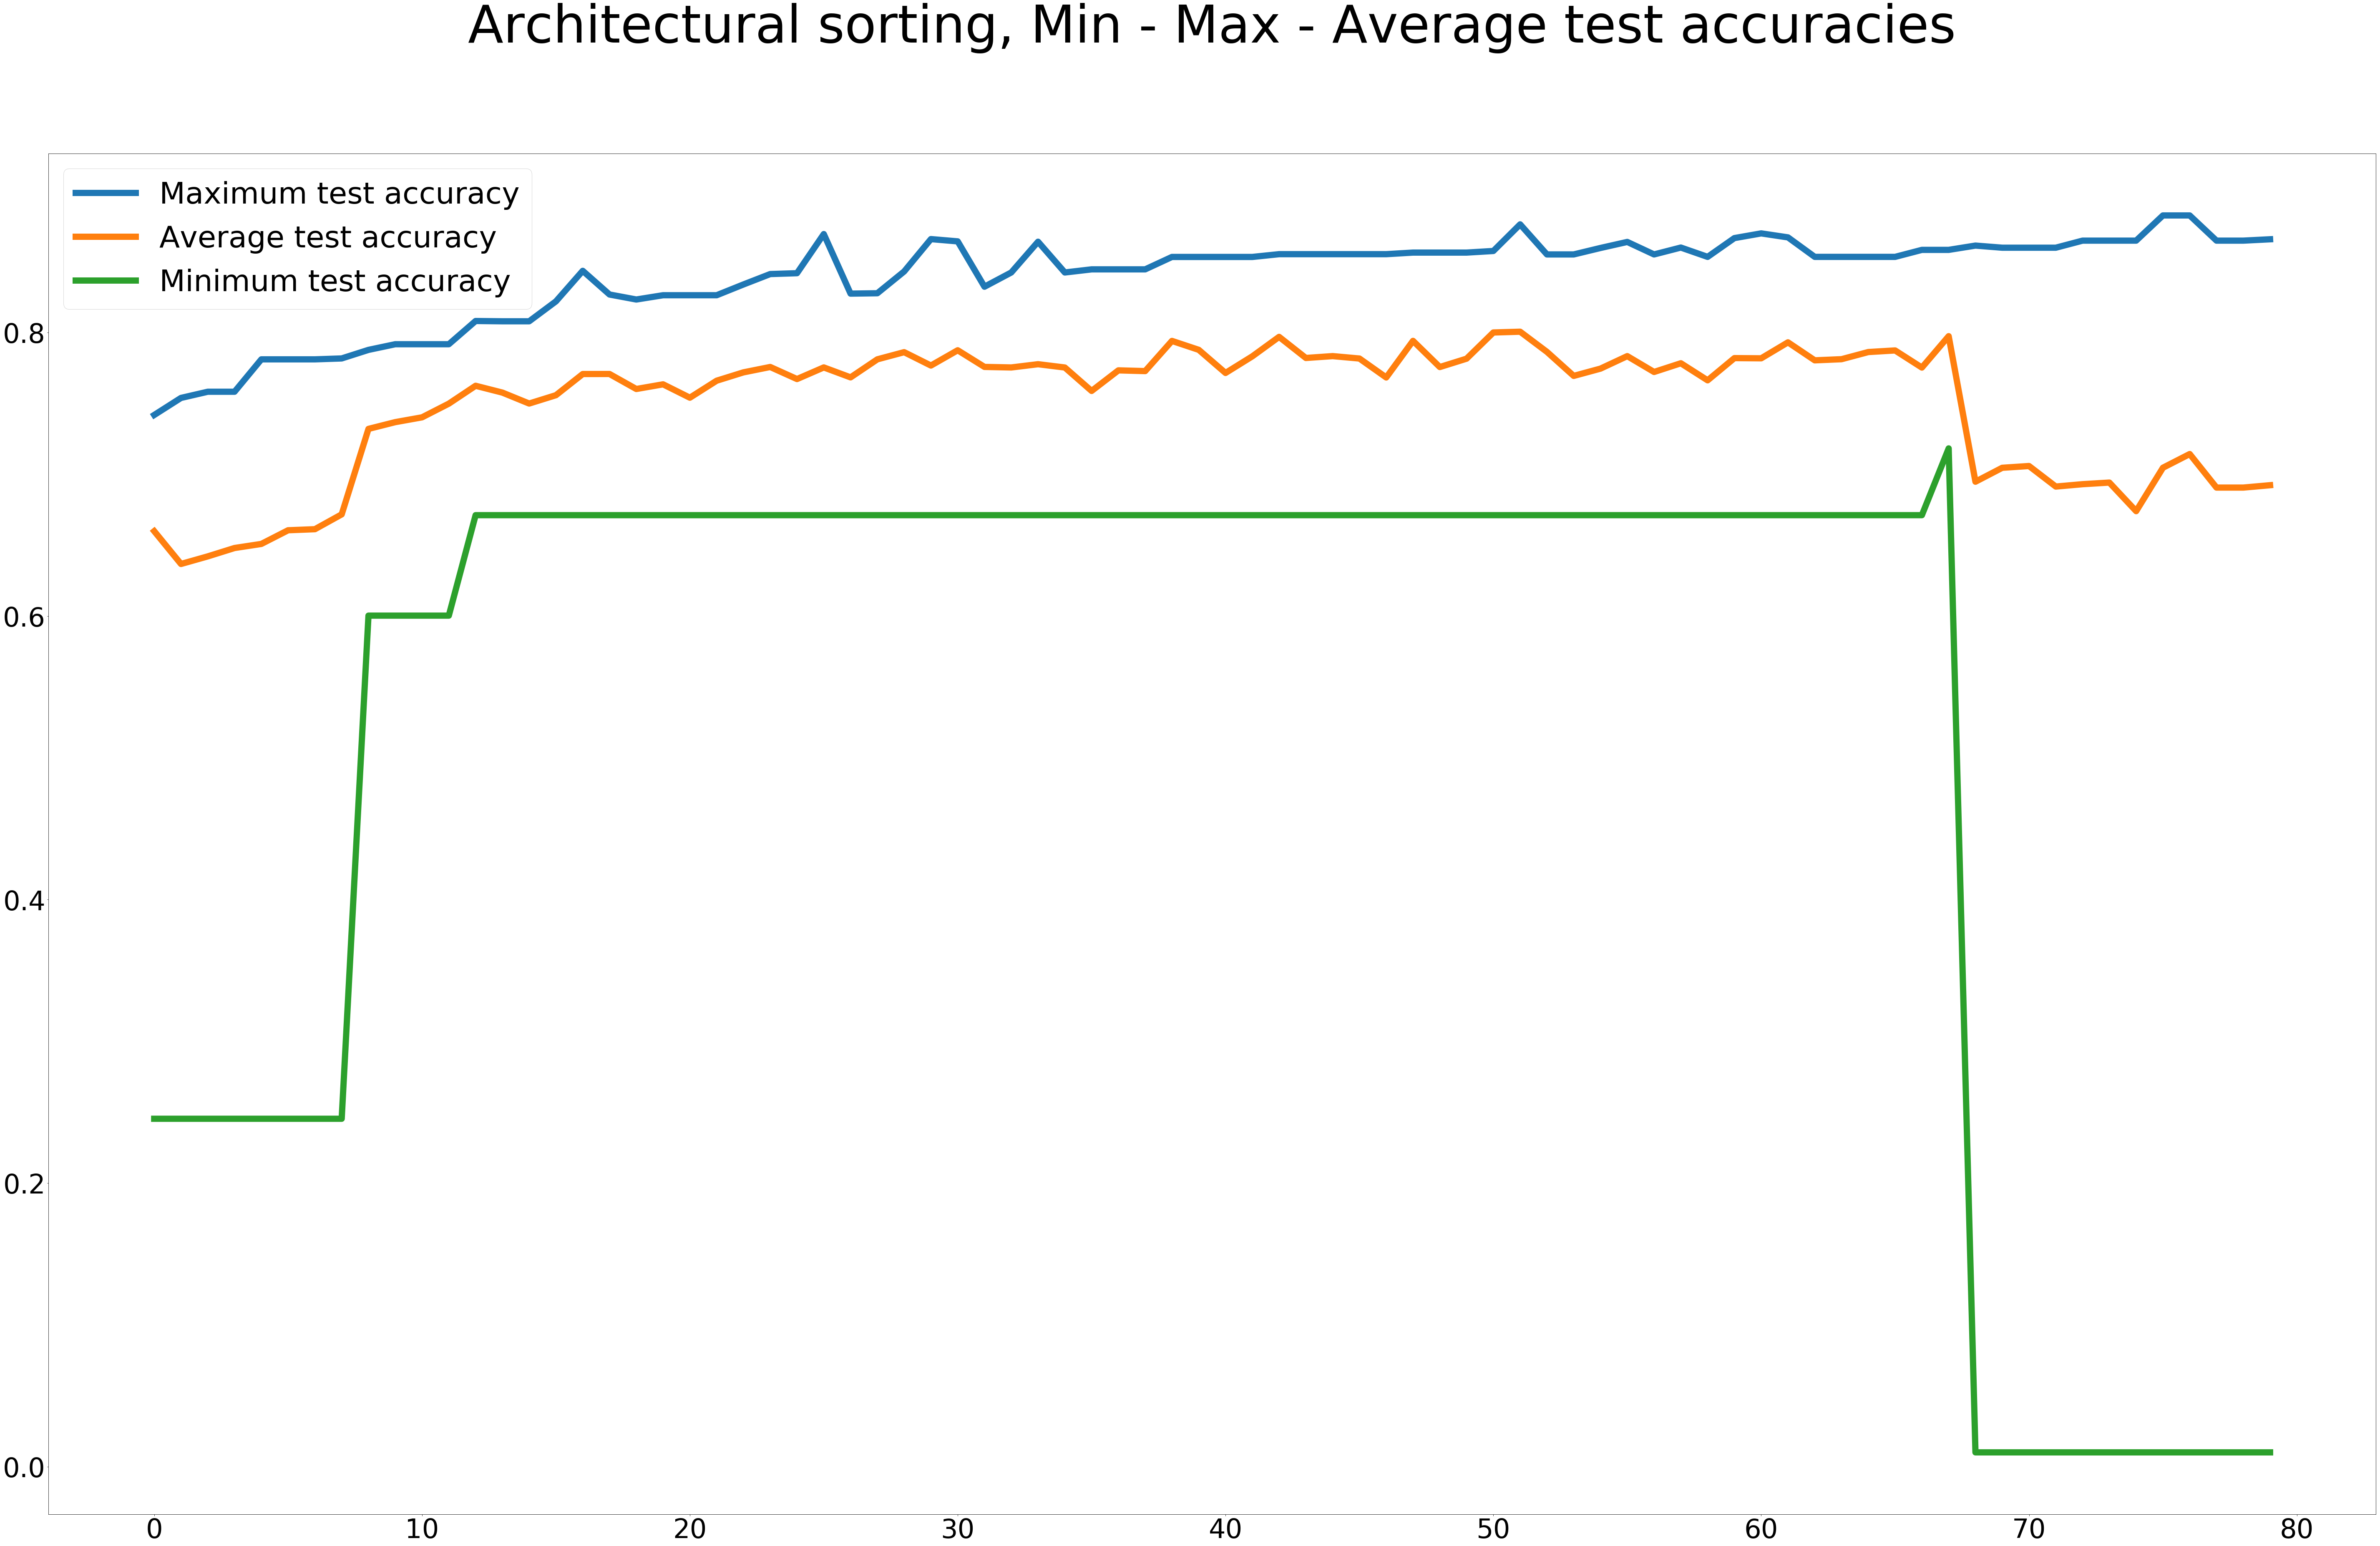

In [101]:
plot_acc(exp03, "Architectural sorting, Min - Max - Average test accuracies")

### Looking at types of nodes within the population for each generation

In [122]:
from src.buildingblocks.ops import pooling, dense, convolution

def best_individ_in_generation(generation):
    best = None
    for ind in generation:
        if not best:
            best = ind
            continue

        if best.test_acc() < ind.test_acc():
            best = ind
    return best

def plot_nodetypes(exp, title):
    gens = list(range(len(exp.generations)))
    p, c, d, t = [], [], [], []
    p_b, c_b, d_b, t_b = [], [], [], []
    for gen in exp.generations:
        p += [len([x for ind in gen for x in ind.children if isinstance(x, pooling.Pooling)]) / len(gen)]
        d += [len([x for ind in gen for x in ind.children if isinstance(x, dense.Dense)]) / len(gen)]
        c += [len([x for ind in gen for x in ind.children if isinstance(x, convolution.Conv2D)]) / len(gen)]
        t += [sum([len(ind.children) for ind in gen]) / len(gen)]
        
        best = best_individ_in_generation(gen)
        p_b += [len([x for x in best.children if isinstance(x, pooling.Pooling)])]
        d_b += [len([x for x in best.children if isinstance(x, dense.Dense)])]
        c_b += [len([x for x in best.children if isinstance(x, convolution.Conv2D)])]
        t_b += [len(best.children)]
        
    labels=[
        "Avg Pooling Layers", "Avg Conv2D Layers", "Avg Dense Layers", "Avg Total Layers",
        "Top Pooling Layers", "Top Conv2D Layers", "Top Dense Layers", "Top Total Layers" 
    ]
    plotter(x=[p, c, d, t, p_b, c_b, d_b, t_b], y=gens, labels=labels, title=title)
    

SyntaxError: invalid syntax (<ipython-input-122-35cb591037ad>, line 15)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


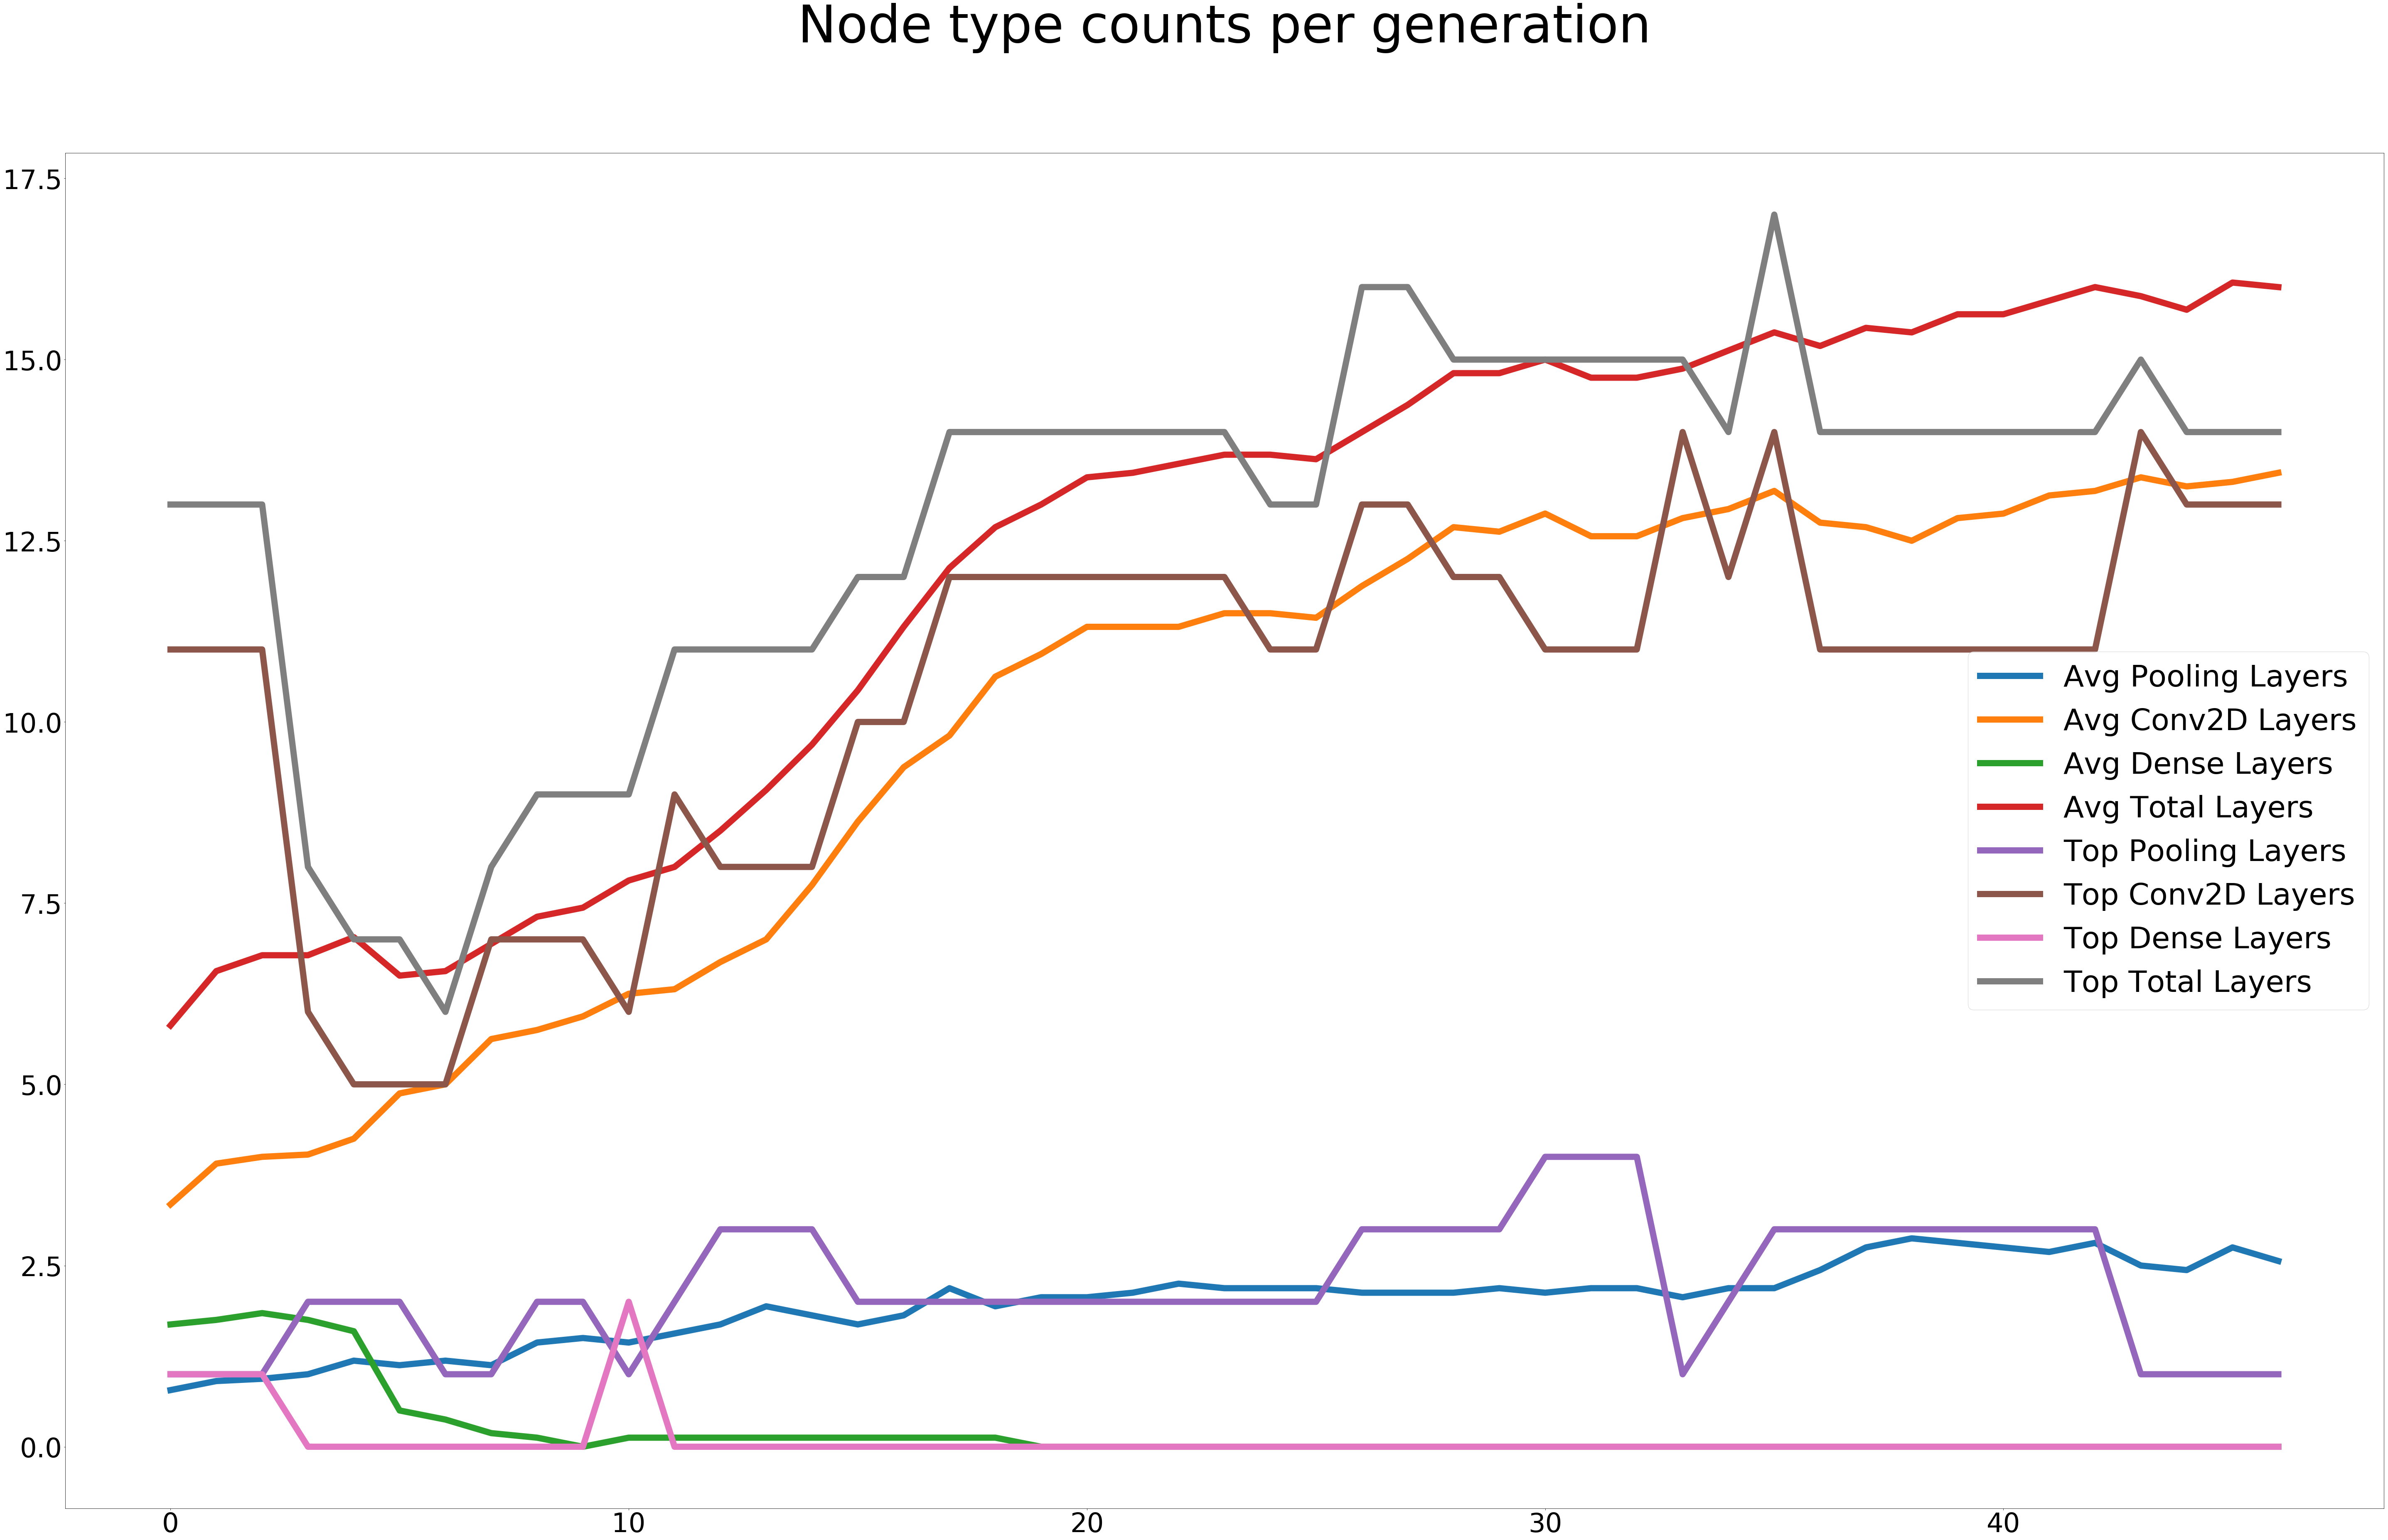

In [123]:
plot_nodetypes(exp02, "Node type counts per generation")

### Correlation between test accuracy and number of layers?
* Plot within ranges of usage for each layer. 

In [170]:
def plot_correlation_acc_layer_type(exp, acc_type, title):
    gens = list(range(len(exp.generations)))

    types = [("Conv2D", convolution.Conv2D), ("Pooling", pooling.Pooling), ("Dense", dense.Dense)]
    avg_layer_count = {key: [] for key, _ in types}
    for gen in exp.generations:
        for name, layer_type in types:
            avg_layer_count[name] += [
                sum([
                    len([
                        x for x in ind.children if isinstance(x, layer_type)
                    ]) for ind in gen
                ]) / len(gen)
            ]
        
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    for (name, type), avg in zip(types, avg_layer_count.values()):
        lbl = f"Average {name} layer count"
        ax1.plot(gens, avg, linewidth=15, label=lbl)
    ax2.plot(gens, exp.avg_test_acc, linewidth=15, label="Test set accuracy")
    plot_setup(ax1, "Average layer count")
    plot_setup(ax2, "Average test accuracy")
    plt.show()

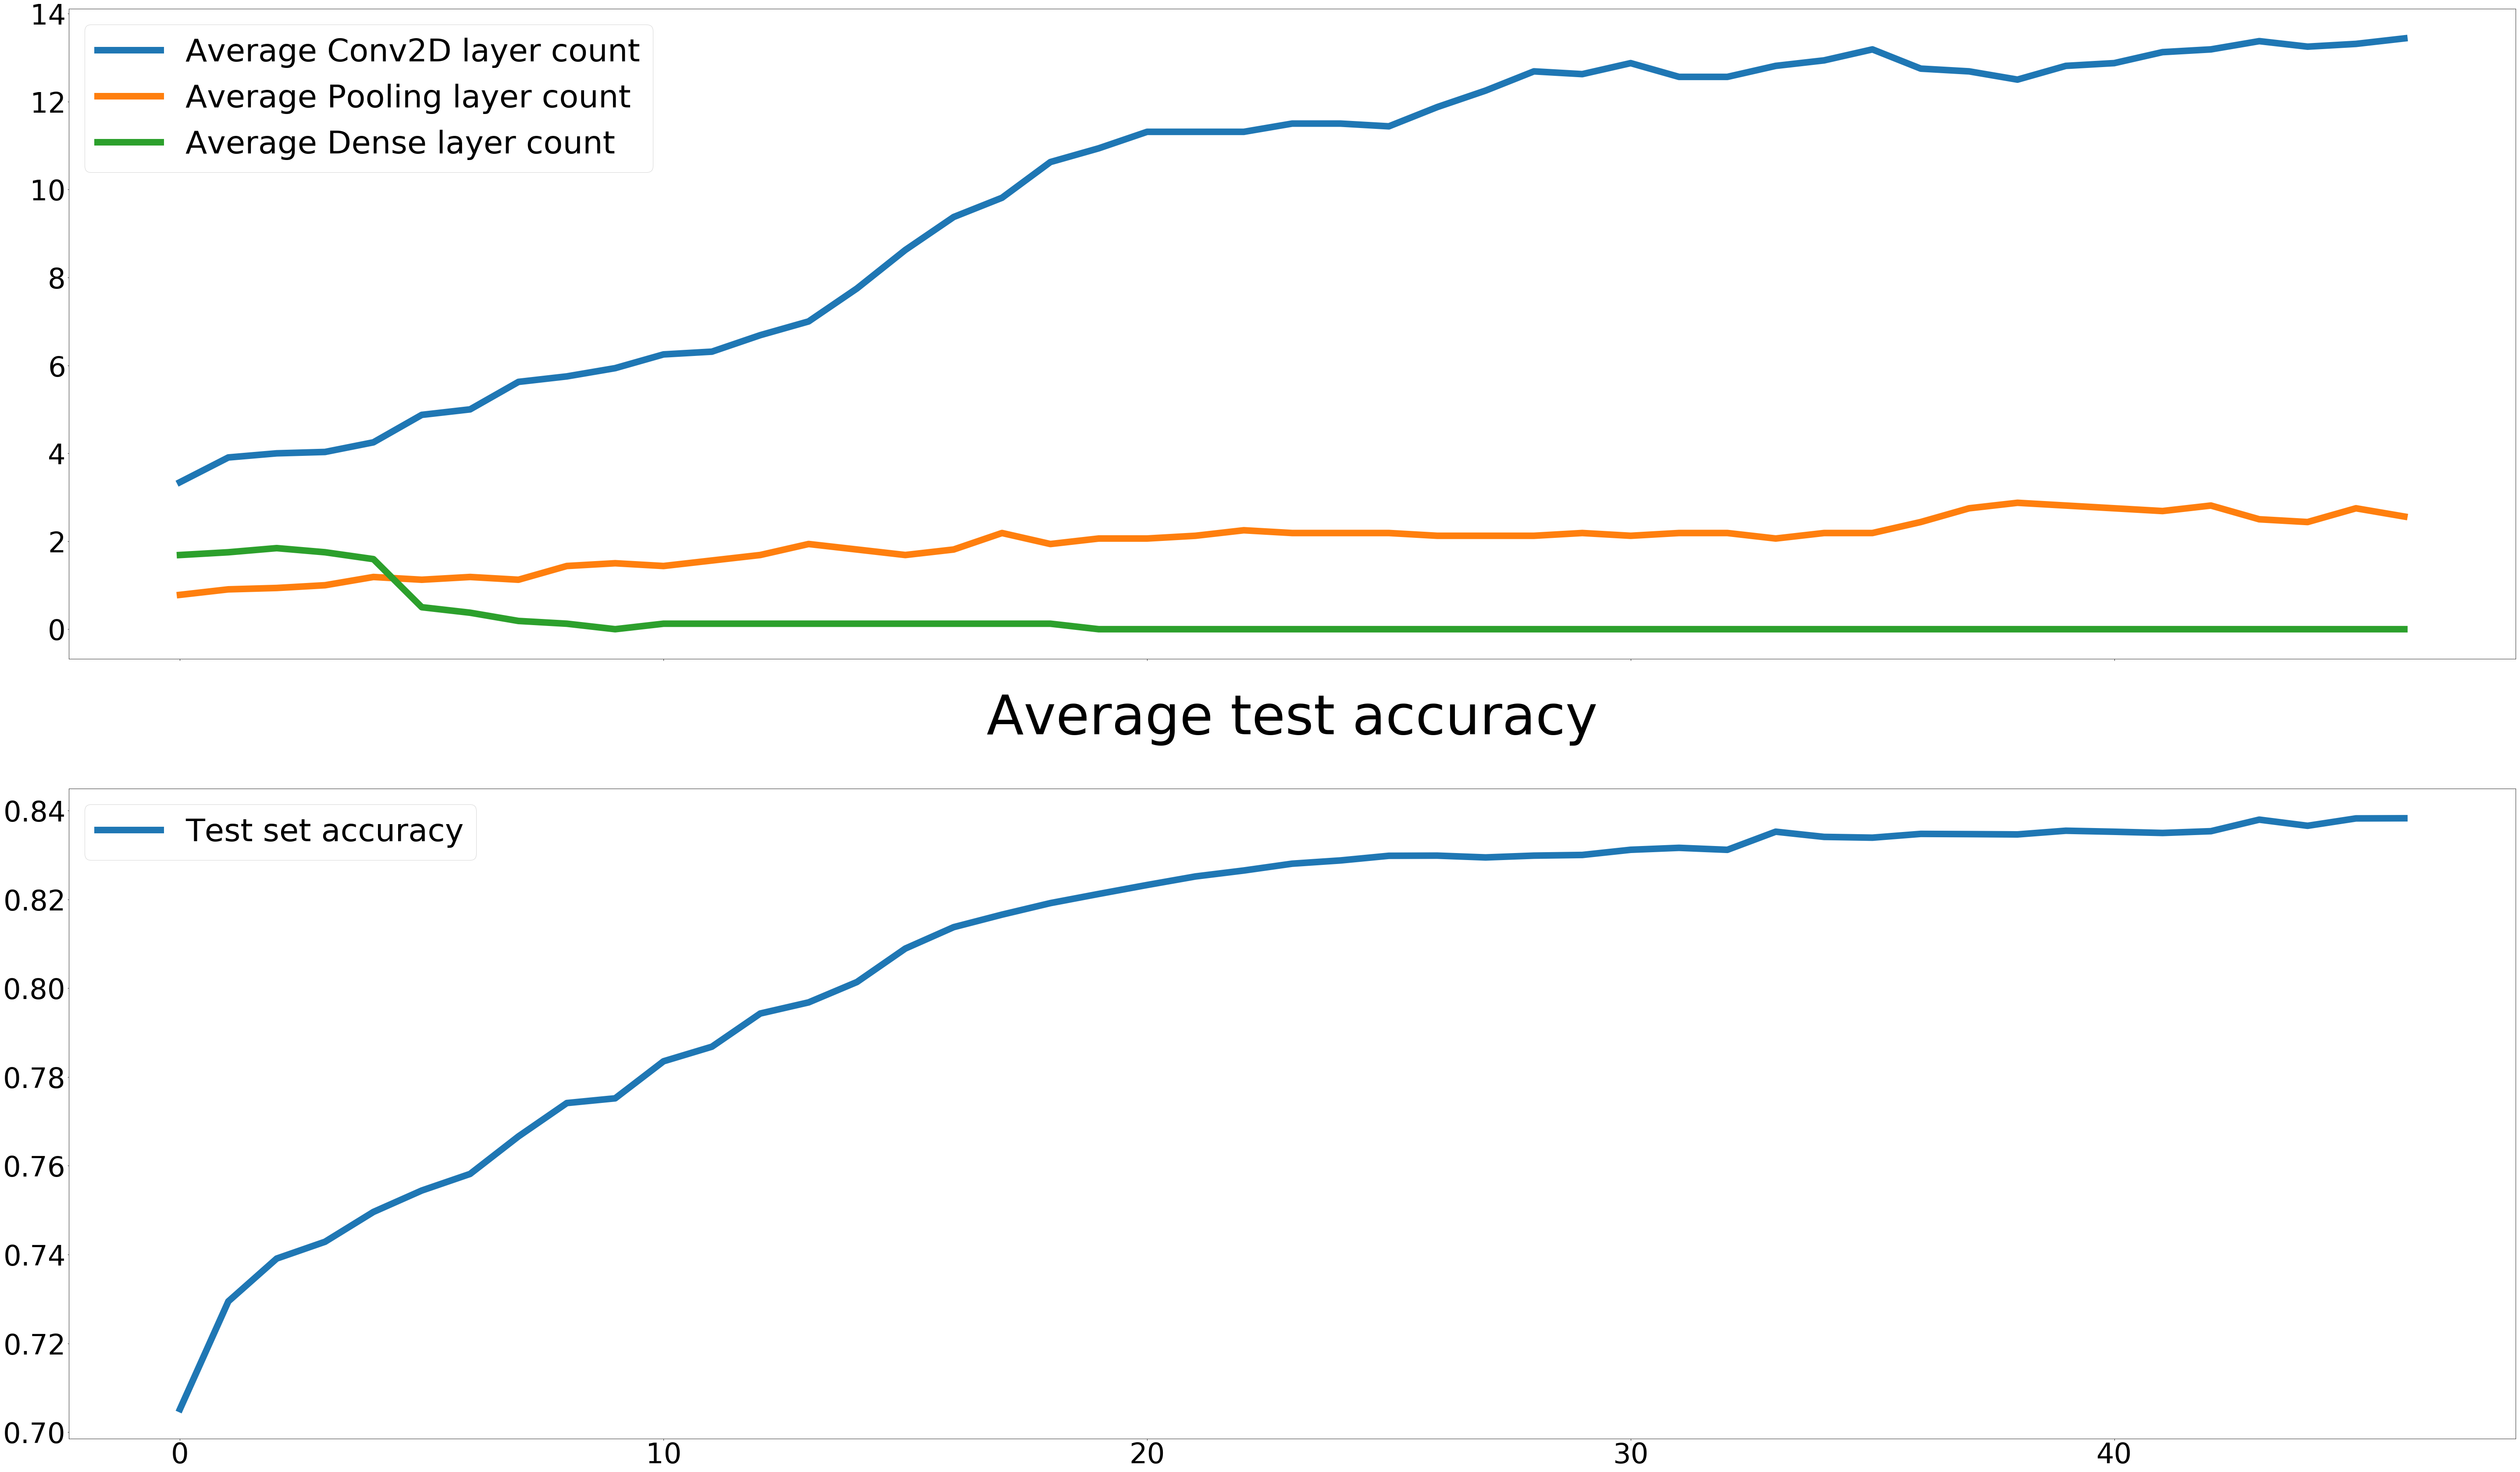

In [301]:
plot_correlation_acc_layer_type(
    exp02, 
    acc_type="test",
    title="Conv2D over Test ACC"
)

# Playing with transfer learning data
* Find average lost knowledge in transfer learning with successor
* Follow the best overall through its entire training
* More cool stuff


In [302]:
def plot_transfer_learning_acc(exp, exp_name):
    def reports_until_certain_epoch(module, epoch, previous_epochs):
        keys = list(module.report.keys())
        keys.sort()
        return [(key + previous_epochs, report) for key, report in module.report.items() if key <= epoch]
        
    def gather_recursivly(current, start_epoch):
        """ Traverse backwards gathering accuracies """
        epochs = current.fitness[:start_epoch]
        lines = [start_epoch]
        if current.predecessor:
            prior_epochs, prior_lines, prior_reports = gather_recursivly(
                current.predecessor, 
                current.immediate_transferred_knowledge_epochs
            )
            
            reports = reports_until_certain_epoch(current, start_epoch, len(prior_epochs))
            return prior_epochs + epochs, prior_lines + lines, reports + prior_reports
        return [], lines, []
        
    best = best_individ_in_generation(exp.generations[-1])
    for num, gen in enumerate(exp.generations):
        if f"{best.name} v0" in [x.ID for x in gen]:
            print(f"{best.name}, the best in the last population was first seen in generation {num}")
            break
    
    epochs, lines, reports = gather_recursivly(best, best.epochs_trained)
    
    cumulative_line_add = [sum(lines[:i]) for i in range(len(lines))]
    
    title = f"Training set accuracy over generations for Best individ ({exp_name})"
    ax = plt.subplot(111)
    plt.plot(range(len(epochs)), epochs, linewidth=15, label="Training set accuracy")
    plot_setup(ax, title)
    
    for spawn in cumulative_line_add:
        plt.plot([spawn, spawn], [0, 1], lw=3, dashes=[2, 2], color="#000000")
        
    for epoch, report in reports:
        num = report['weighted avg']["precision"]
        plt.plot(epoch, num, lw=20, markersize=30, marker='o', color="#00ff00")
    plt.plot()
    plt.savefig(f"/Users/magnus/Desktop/{title}.png")

Marcin, the best in the last population was first seen in generation 0


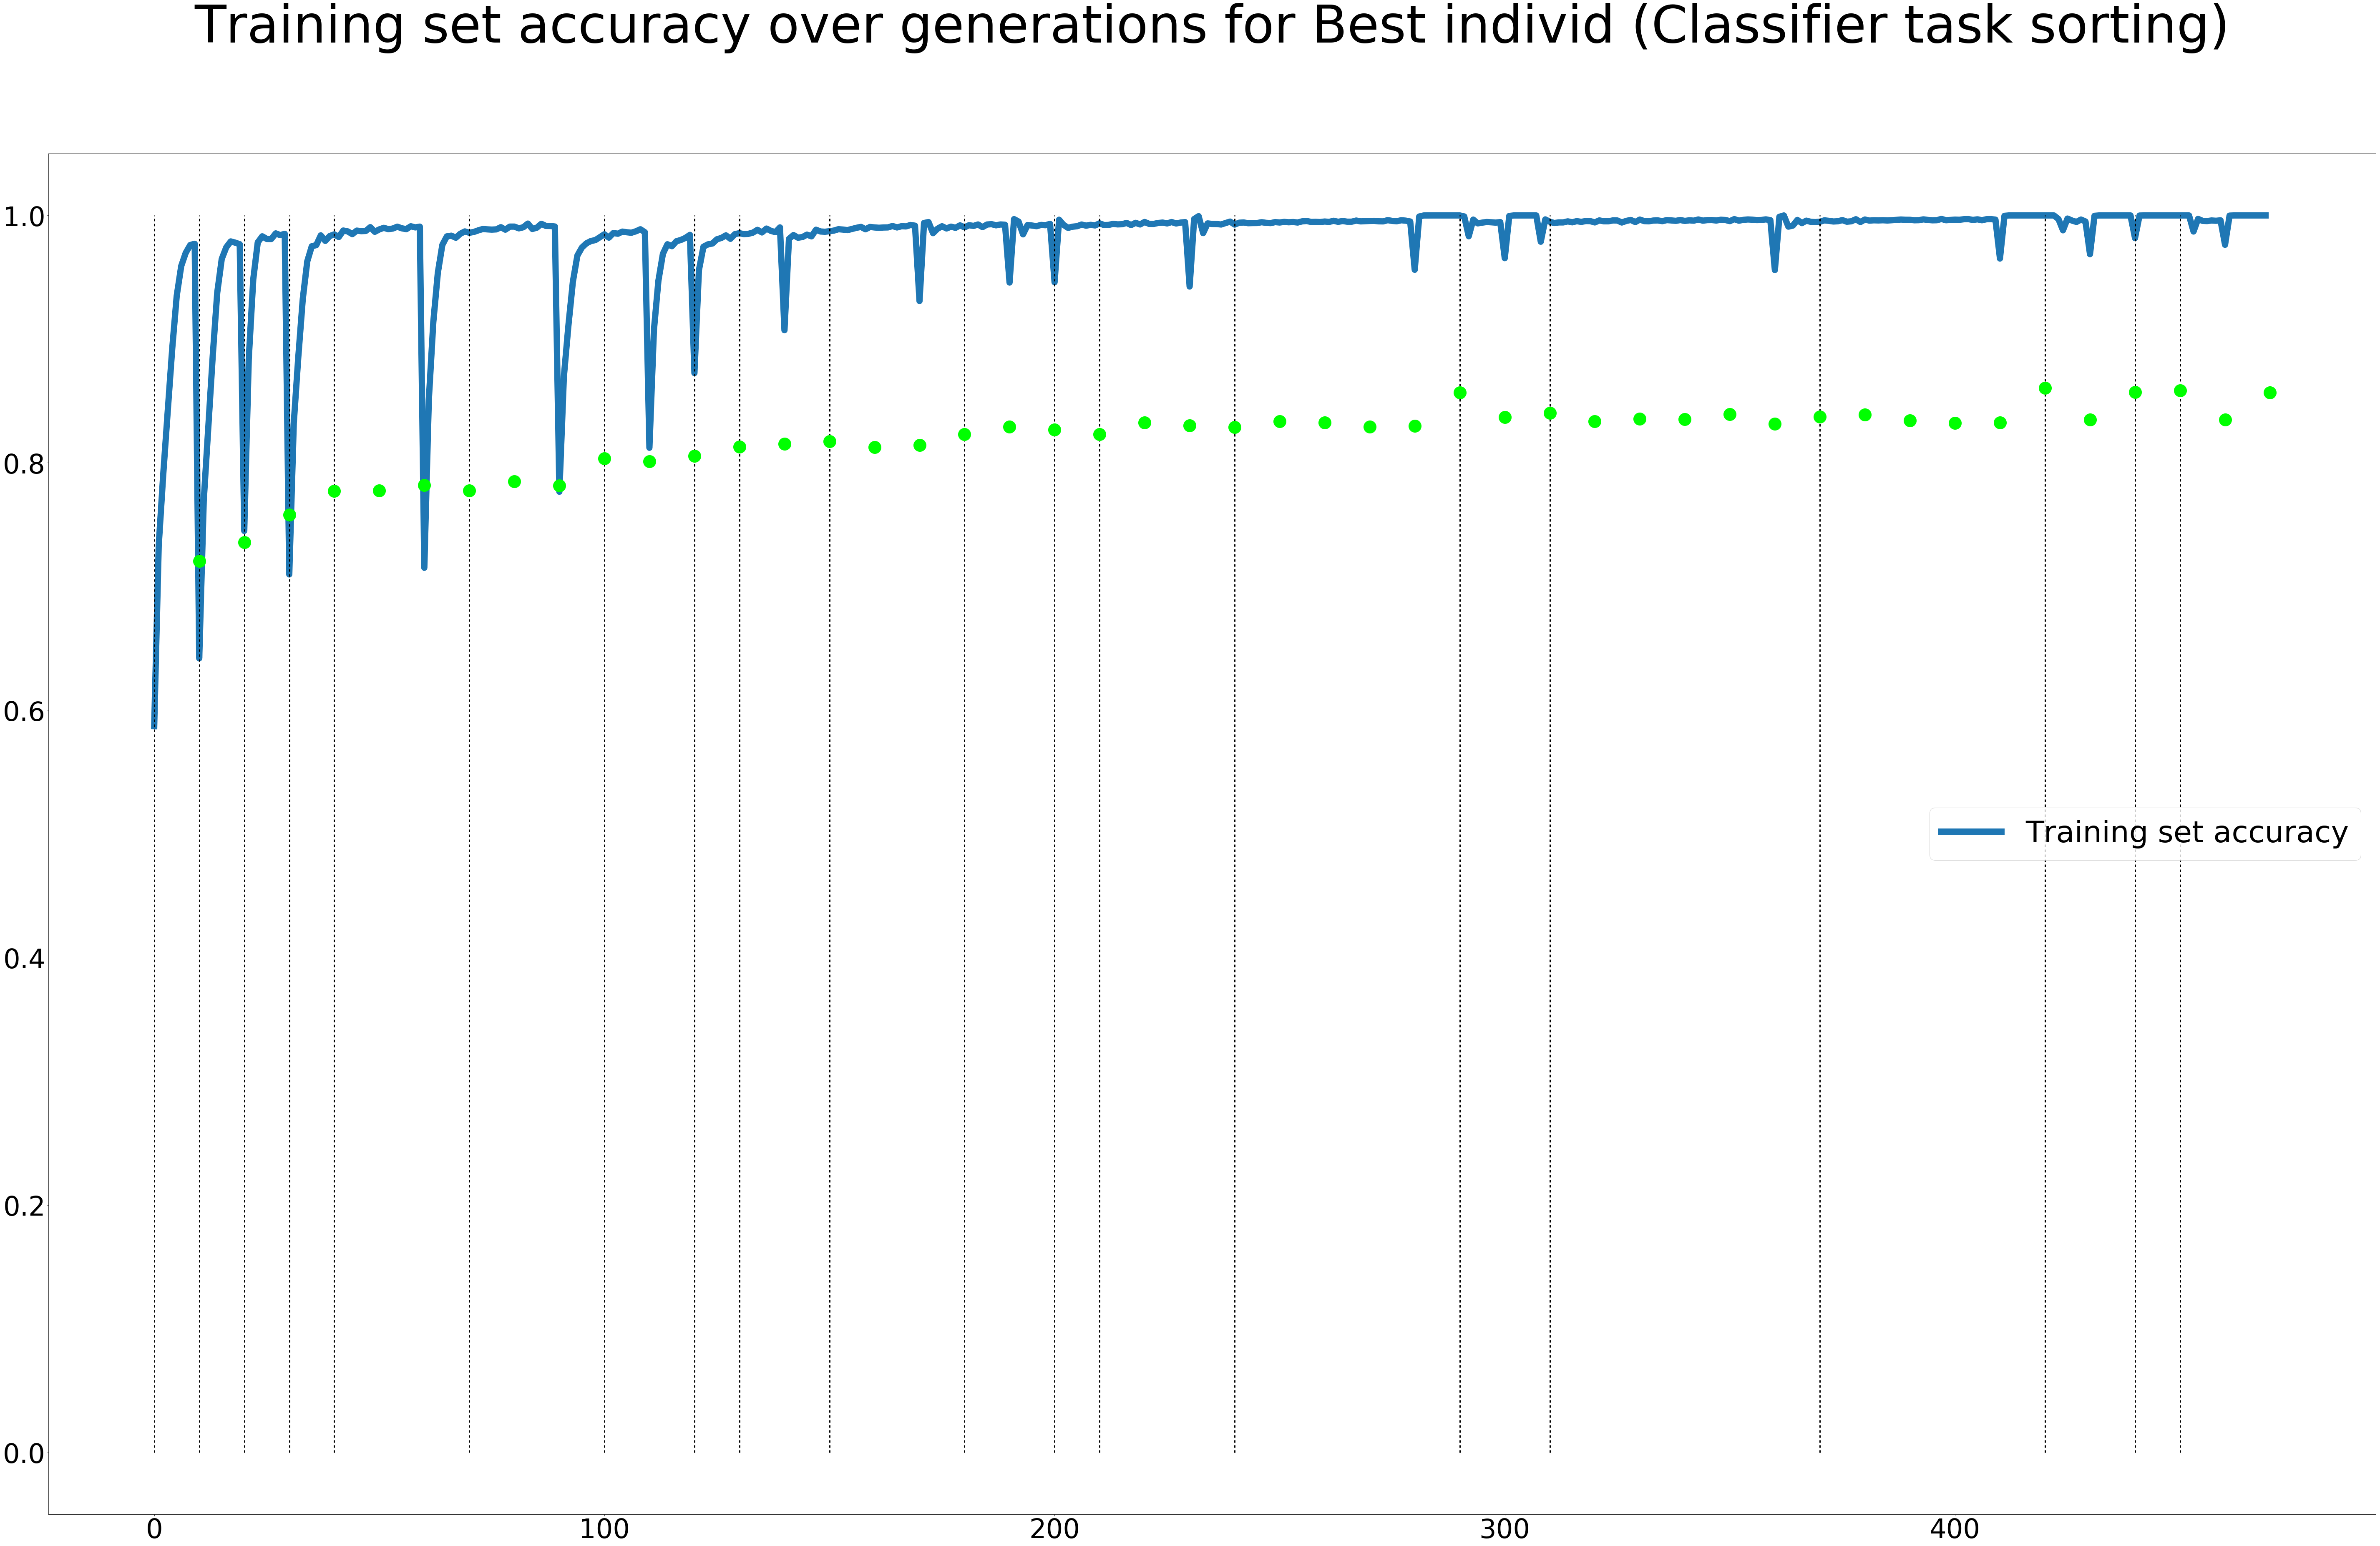

In [303]:
plot_transfer_learning_acc(exp02, "Classifier task sorting")

Lisbet, the best in the last population was first seen in generation 2


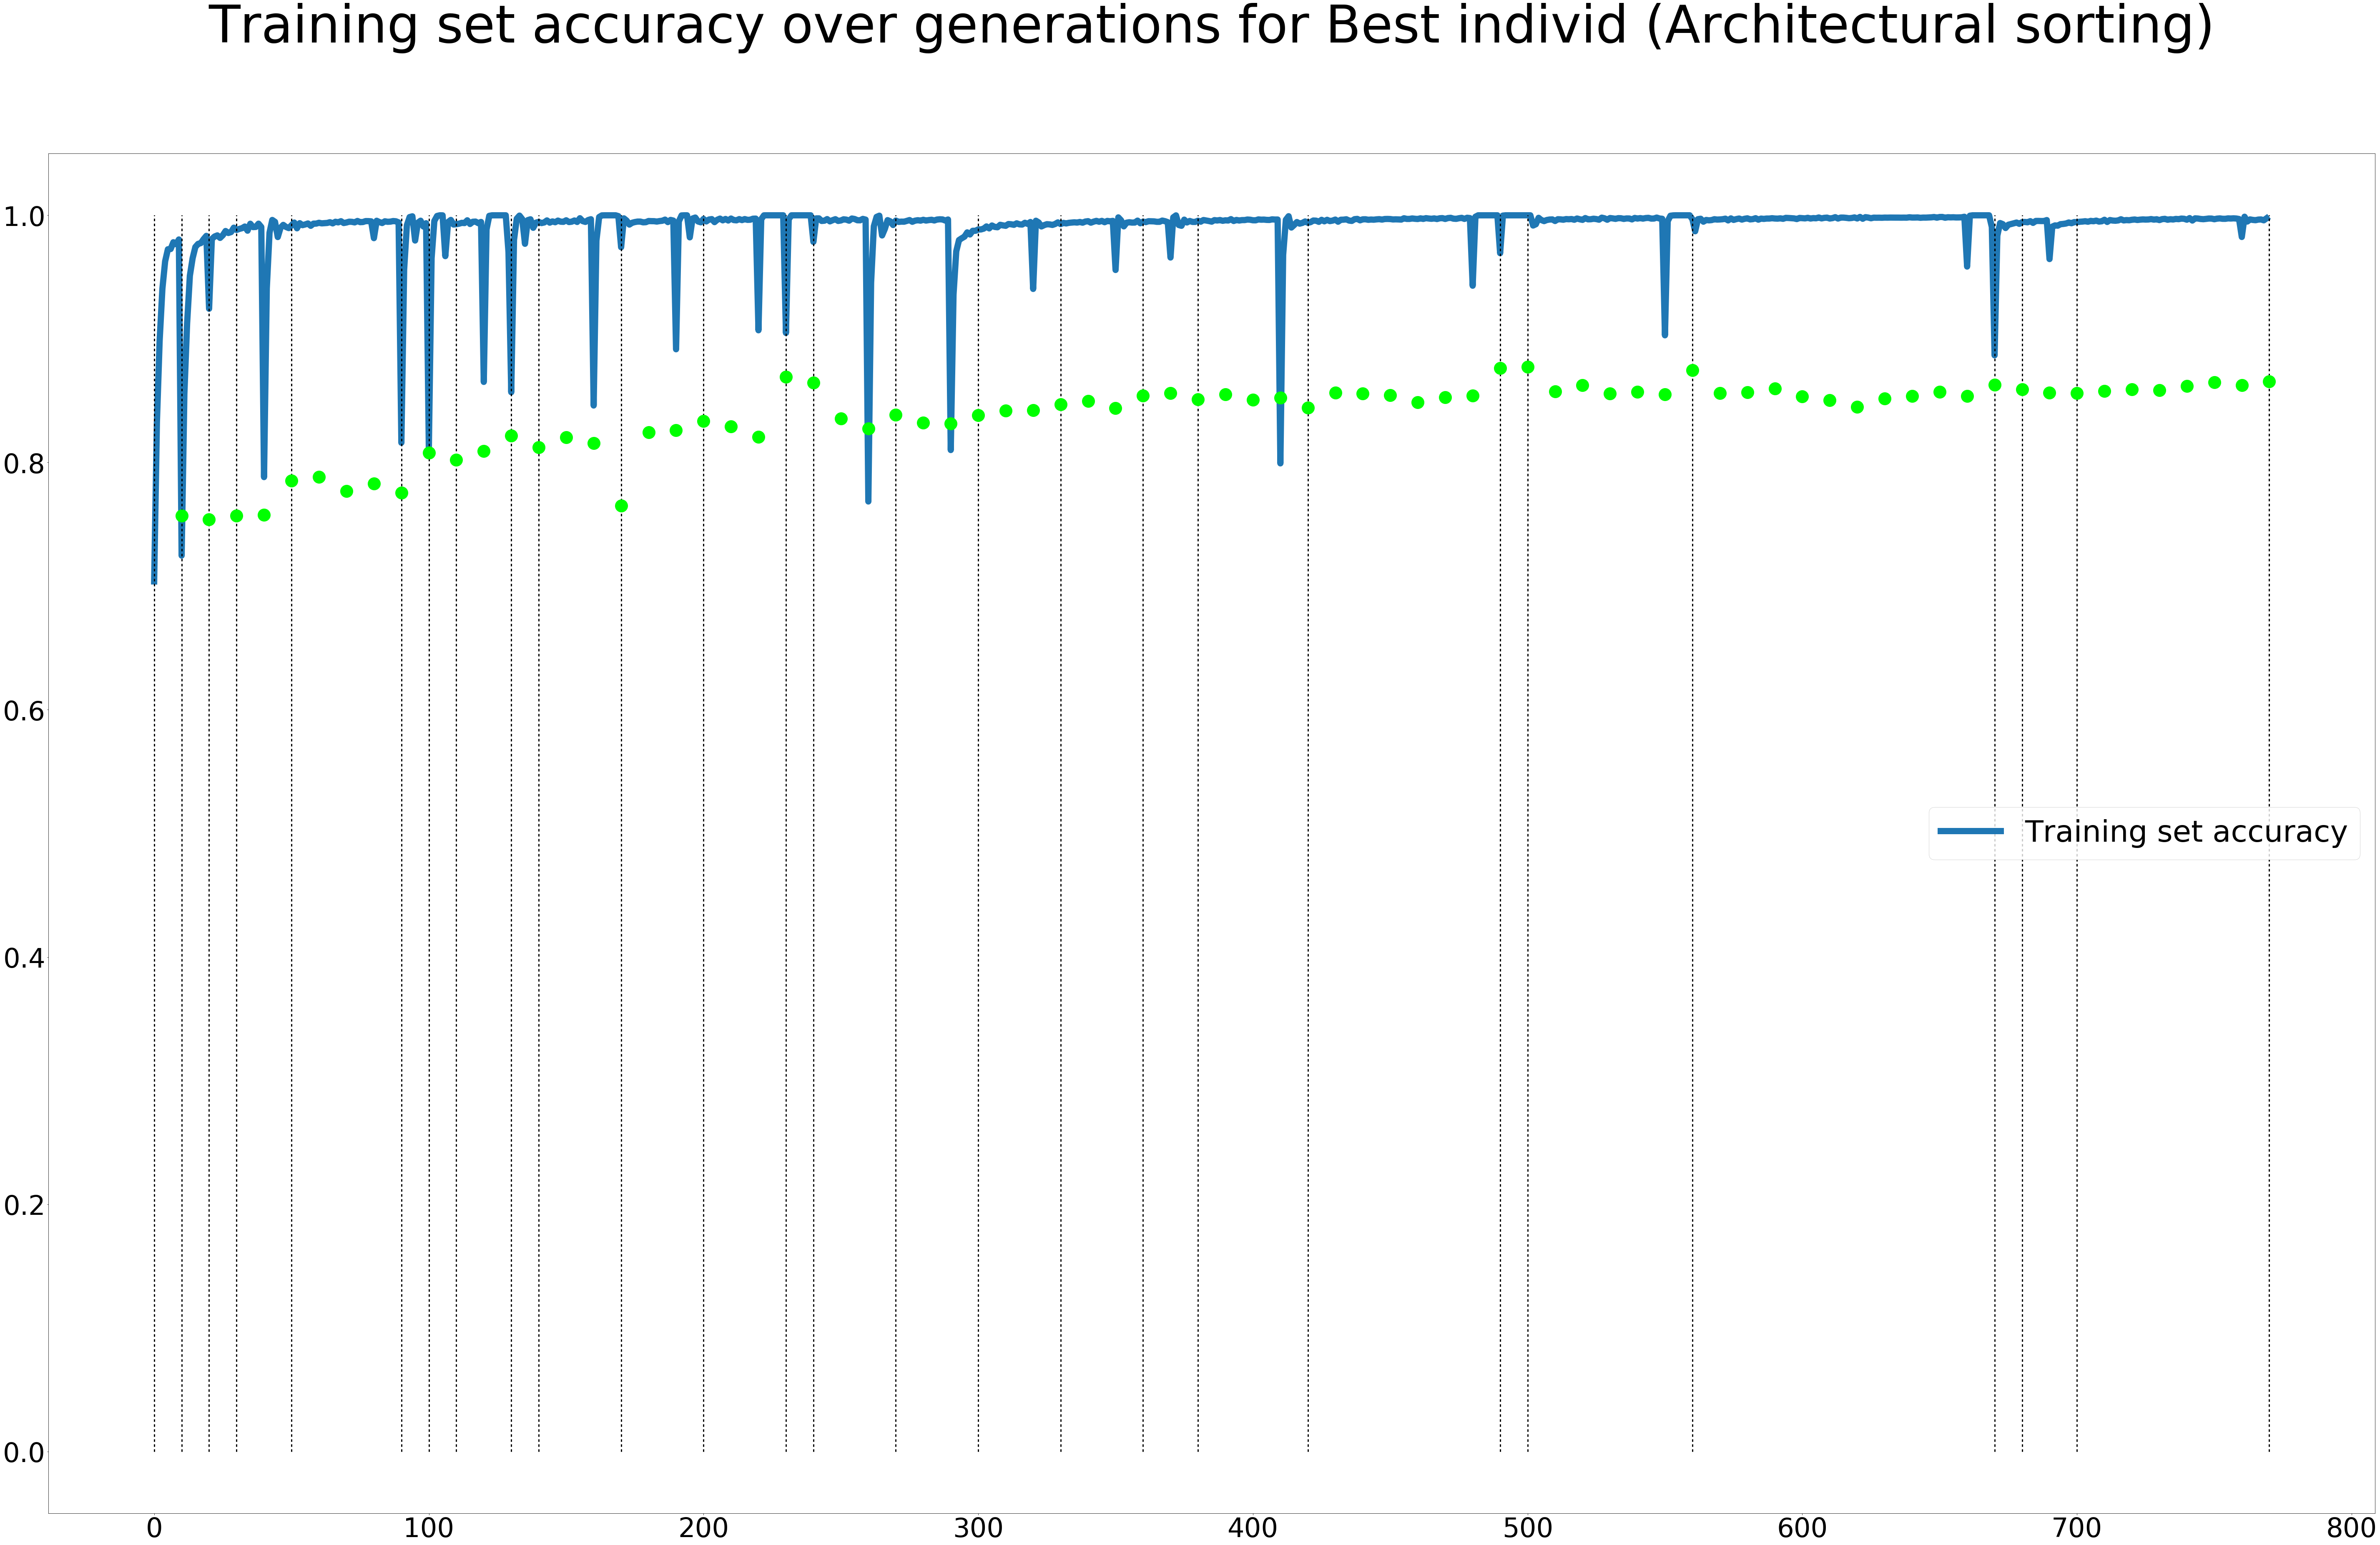

In [304]:
plot_transfer_learning_acc(exp03, "Architectural sorting")

One note about the plot above, One epoch of training has to occur before any evaluation of training set can be gathered. This means loss between offspring and parent might be larger than it seems. 